In [42]:
## Read the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

telecom_data = pd.read_csv("telecom_churn_data.csv")
print(telecom_data.shape)
telecom_data.head()

(99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [43]:
## Data Clean on churn attribs
print("Shape before dropping", telecom_data.shape)
telecom_data = telecom_data.dropna(subset = ["total_ic_mou_9", "total_og_mou_9", "vol_2g_mb_9", "vol_3g_mb_9"])
print("Shape after dropping", telecom_data.shape)

## Applying churn as given in the assignment
def churn_test(row):
    return  (1 if (row["total_ic_mou_9"] == 0 and
                   row["total_og_mou_9"] == 0 and
                   row["vol_2g_mb_9"] == 0 and
                   row["vol_3g_mb_9"] == 0) else 0)

telecom_data["churn"] = telecom_data.apply(lambda row: churn_test(row), axis=1)


Shape before dropping (99999, 226)
Shape after dropping (99999, 226)


In [44]:
telecom_data = telecom_data.dropna(subset = ['total_rech_amt_6', 'total_rech_amt_7'])
print("Shape :: ", telecom_data.shape)
telecom_data['av_rech_amt_data_6_7'] = (telecom_data['av_rech_amt_data_6'] + telecom_data['av_rech_amt_data_7']) / 2
telecom_data['total_rech_amt_6_7'] = (telecom_data['total_rech_amt_6'] + telecom_data['total_rech_amt_7']) / 2
high_value_cutoff = telecom_data['total_rech_amt_6_7'].quantile(0.7)
print(high_value_cutoff)
telecom_data = telecom_data[telecom_data['total_rech_amt_6_7'] >= high_value_cutoff]
print(telecom_data.shape)

Shape ::  (99999, 227)
368.5
(30011, 229)


In [45]:
telecom_data.drop(list(filter(lambda x: x.endswith("_9"), telecom_data.columns)), inplace=True, axis=1)
print(telecom_data.shape)

(30011, 175)


In [46]:
# Prior Probabilities of churning
prior_prob_churn = telecom_data[telecom_data["churn"] == 1].shape[0] / telecom_data.shape[0]
print("Prior Probabilities of churn", prior_prob_churn)

Prior Probabilities of churn 0.08640165272733331


In [68]:
def analyze_feature(feature_start):
    plt.rcParams["figure.figsize"] = [20, 10]
    fig = plt.figure()
    print("Churn Stats:")
    for month in ["6", "7", "8"]:
        print("Month {}".format(month))
        feature = feature_start + "_" + month
        temp_df = telecom_data.dropna(subset=[feature])[telecom_data["churn"] == 1]
        feat_std = temp_df[feature].std()
        avg = temp_df[feature].mean()
        max_feat = temp_df[feature].max()
        print("Total Rows: {} Std. dev. {} Avg {} max_feat {}".format(temp_df.shape[0], 
                                                                      feat_std, avg, max_feat))
    axes = fig.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0])
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1])
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2])


In [104]:
# Find all features to explore NA not more than 50% zeros not more than 50
columns = list(telecom_data.columns)
columns = list(filter(lambda x: telecom_data[x].isnull().sum(axis = 0) / telecom_data.shape[0] < 0.5, columns))
columns = list(filter(lambda x: telecom_data[x].nonzero()[0].shape[0] / telecom_data.shape[0] > 0.5, columns))
print("Cols to observe {}".format(len(columns)))

# Filter phase level columns
phase_columns = list(filter(lambda x: x.endswith("_6") and "date" not in x, columns))
print("Phase level columns {}".format(len(phase_columns)))
phase_columns = list(set(phase_columns) - set(["last_date_of_month_6"]))

Cols to observe 82
Phase level columns 24


ANALYZING: arpu
Churn Stats:
Month 6
Total Rows: 2593 Std. dev. 551.7928637201724 Avg 678.7169703046663 max_feat 11505.508
Month 7
Total Rows: 2593 Std. dev. 517.2412205709185 Avg 550.511946394138 max_feat 13224.118999999999
Month 8
Total Rows: 2593 Std. dev. 378.84353108490865 Avg 243.06334323177785 max_feat 5228.826
ANALYZING: total_rech_num
Churn Stats:
Month 6
Total Rows: 2593 Std. dev. 11.599847176641266 Avg 14.364057076745082 max_feat 125
Month 7
Total Rows: 2593 Std. dev. 10.390480132690646 Avg 11.612032394909372 max_feat 110
Month 8
Total Rows: 2593 Std. dev. 7.381985862443398 Avg 5.541843424604705 max_feat 196
ANALYZING: std_og_mou
Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 823.1706276653887 Avg 695.3258303176518 max_feat 8432.99
Month 7


/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Total Rows: 2434 Std. dev. 751.4812667900447 Avg 557.4404108463434 max_feat 8155.53
Month 8
Total Rows: 1857 Std. dev. 480.07734423338667 Avg 235.6844749596123 max_feat 5129.38
ANALYZING: loc_og_mou
Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 330.21541517842405 Avg 196.8244229995979 max_feat 3866.49
Month 7
Total Rows: 2434 Std. dev. 270.54653590092 Avg 153.18237469186525 max_feat 3604.84
Month 8
Total Rows: 1857 Std. dev. 163.5301491718654 Avg 72.77983306408186 max_feat 3071.26
ANALYZING: total_og_mou
Churn Stats:
Month 6
Total Rows: 2593 Std. dev. 852.6976882987242 Avg 867.9613420748167 max_feat 8488.36
Month 7
Total Rows: 2593 Std. dev. 786.9613986264452 Avg 677.8689086000771 max_feat 8285.64
Month 8
Total Rows: 2593 Std. dev. 471.67271845765606 Avg 225.08374084072503 max_feat 5206.21
ANALYZING: onnet_mou
Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 605.0828622662567 Avg 425.2376357056695 max_feat 7011.11
Month 7
Total Rows: 2434 Std. dev. 537.1694572660736 Avg 336.1389687756

/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Total Rows: 2434 Std. dev. 260.3061162894023 Avg 144.0406162695152 max_feat 4915.79
Month 8
Total Rows: 1857 Std. dev. 139.05512148337067 Avg 67.99134087237479 max_feat 1744.33
ANALYZING: loc_og_t2t_mou
Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 212.81700010559885 Avg 68.54402090872537 max_feat 3775.46
Month 7
Total Rows: 2434 Std. dev. 149.28031145293687 Avg 50.00857436318817 max_feat 2758.76
Month 8
Total Rows: 1857 Std. dev. 81.0242216039403 Avg 23.35768982229402 max_feat 1342.81
ANALYZING: std_og_t2m_mou
Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 606.5498478691936 Avg 360.8713067953357 max_feat 8314.76
Month 7
Total Rows: 2434 Std. dev. 548.7565611266527 Avg 292.63667214461793 max_feat 6293.28
Month 8
Total Rows: 1857 Std. dev. 299.4165732197123 Avg 117.0215239633818 max_feat 4008.94


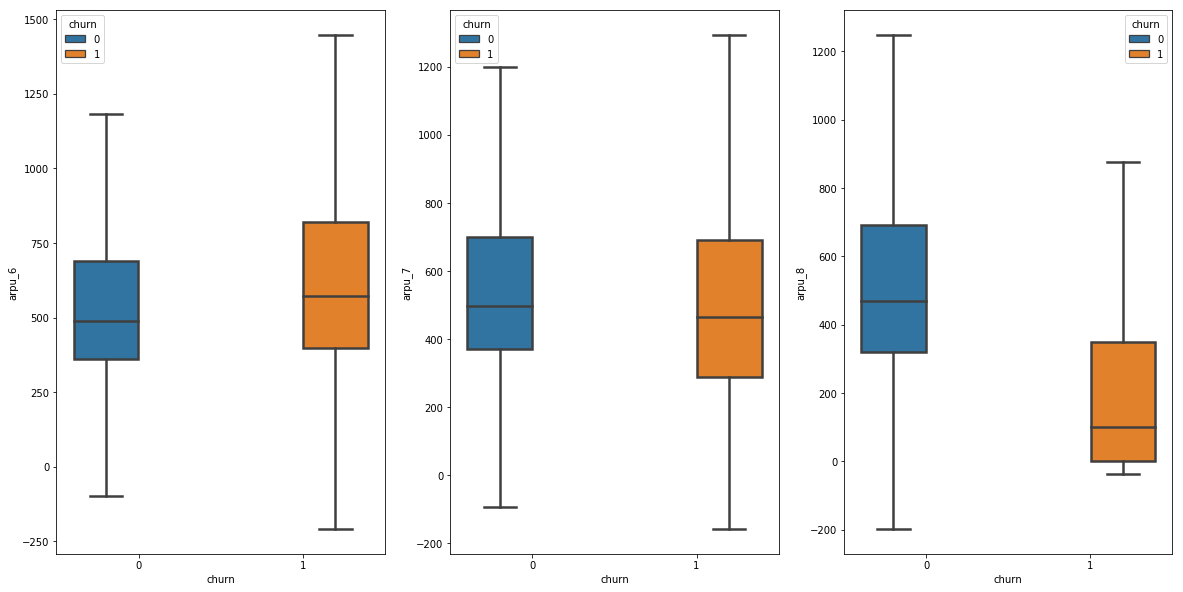

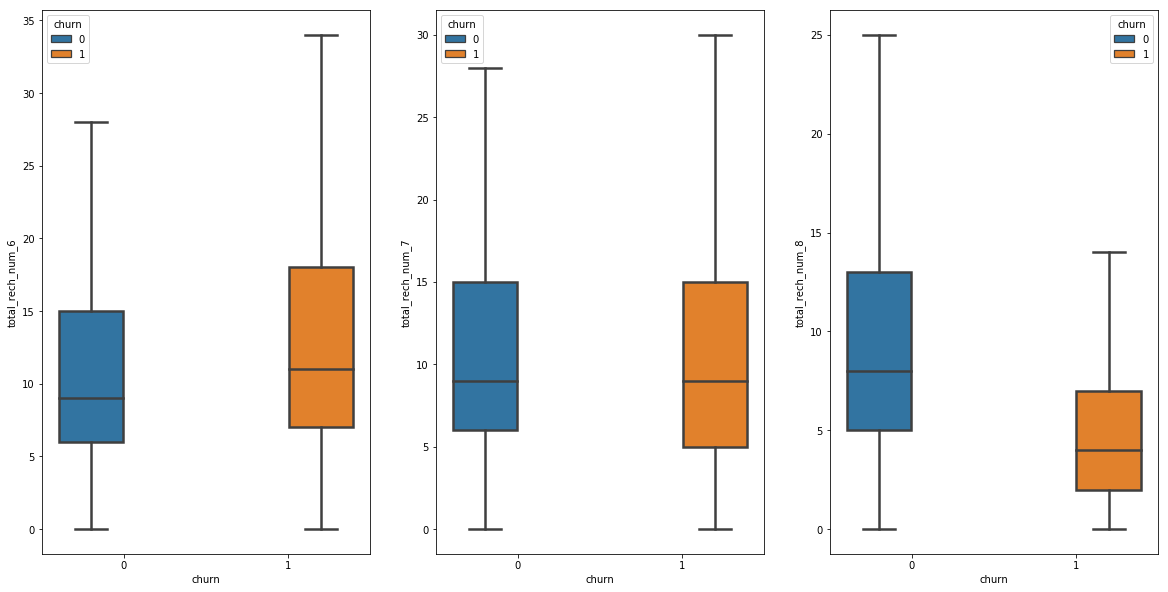

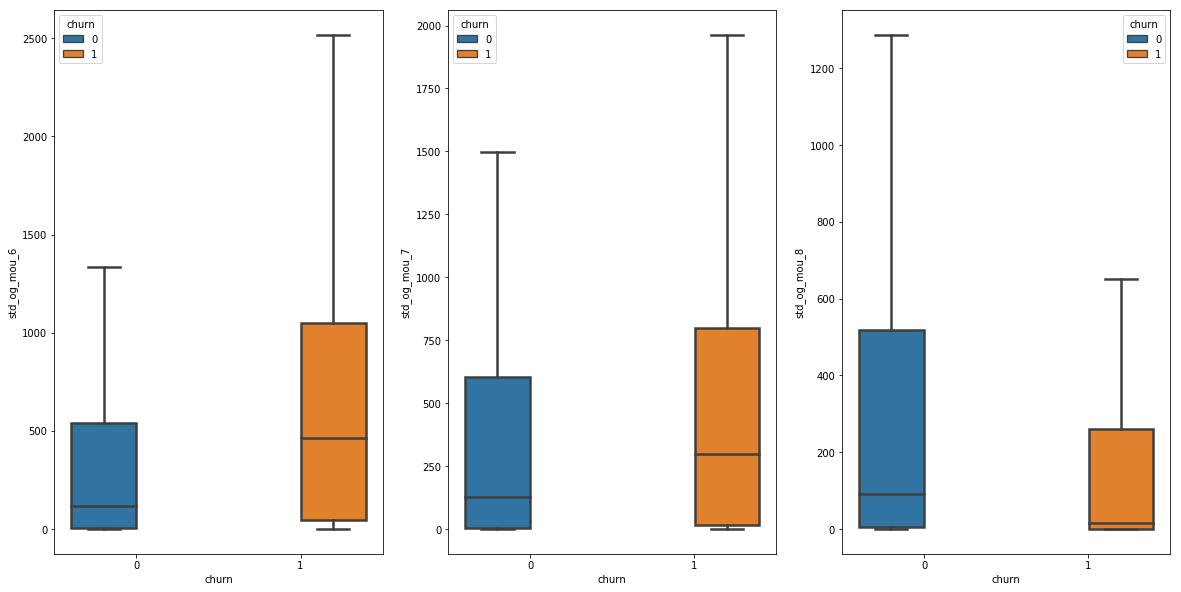

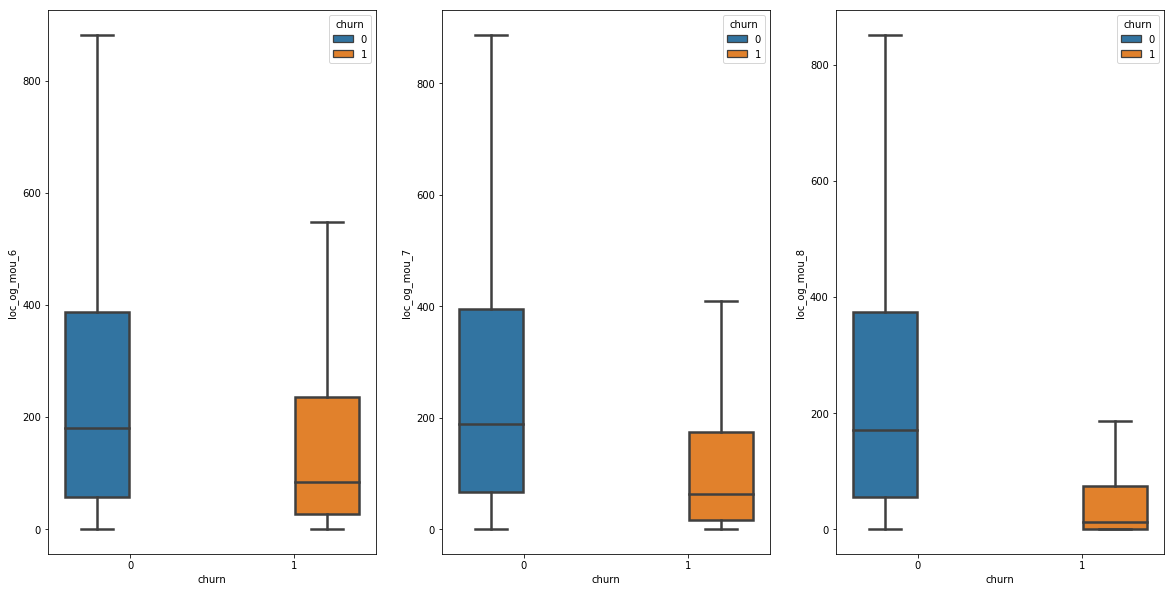

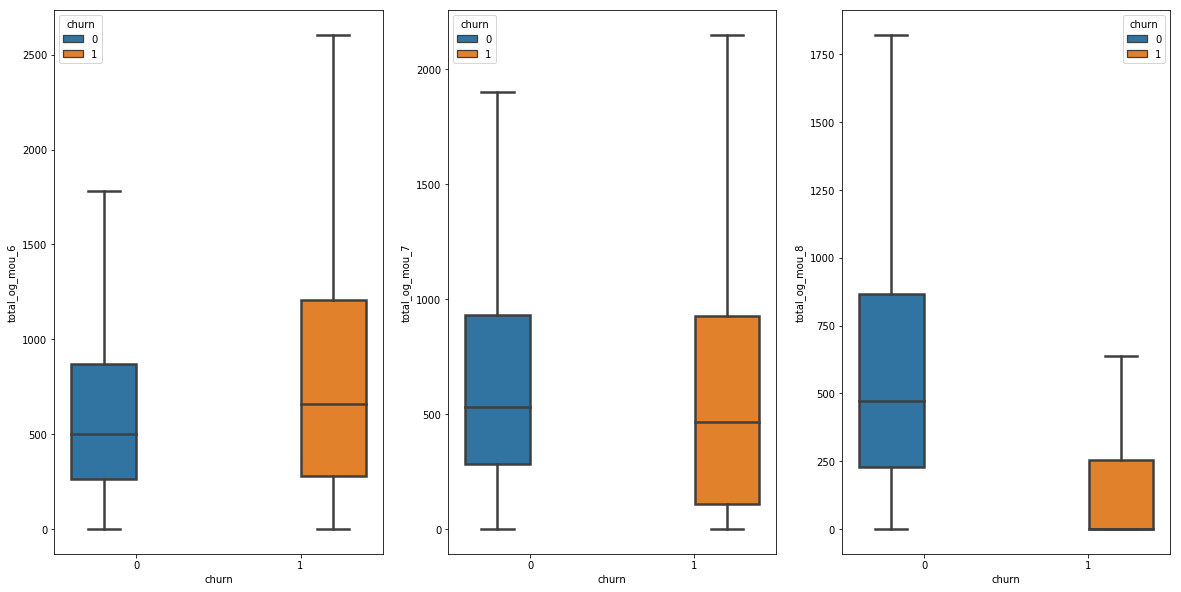

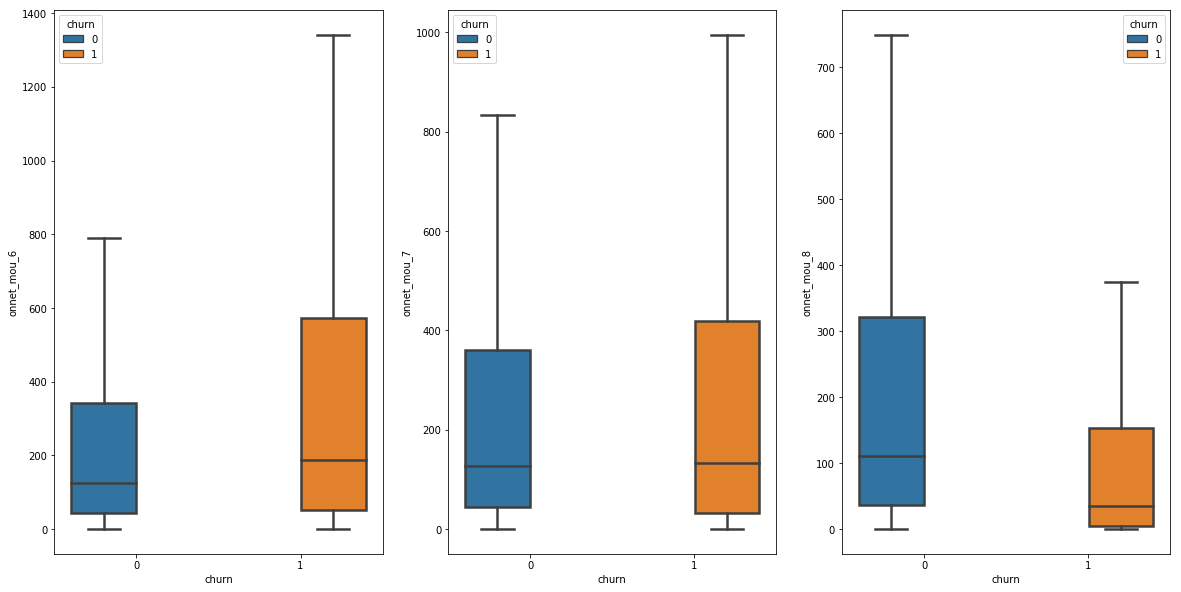

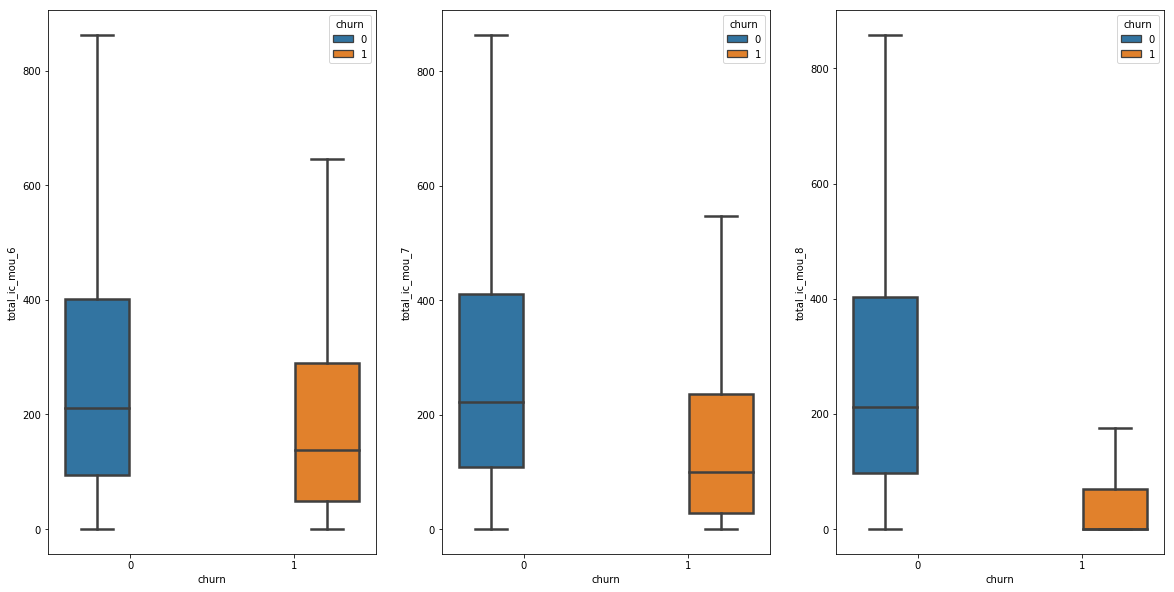

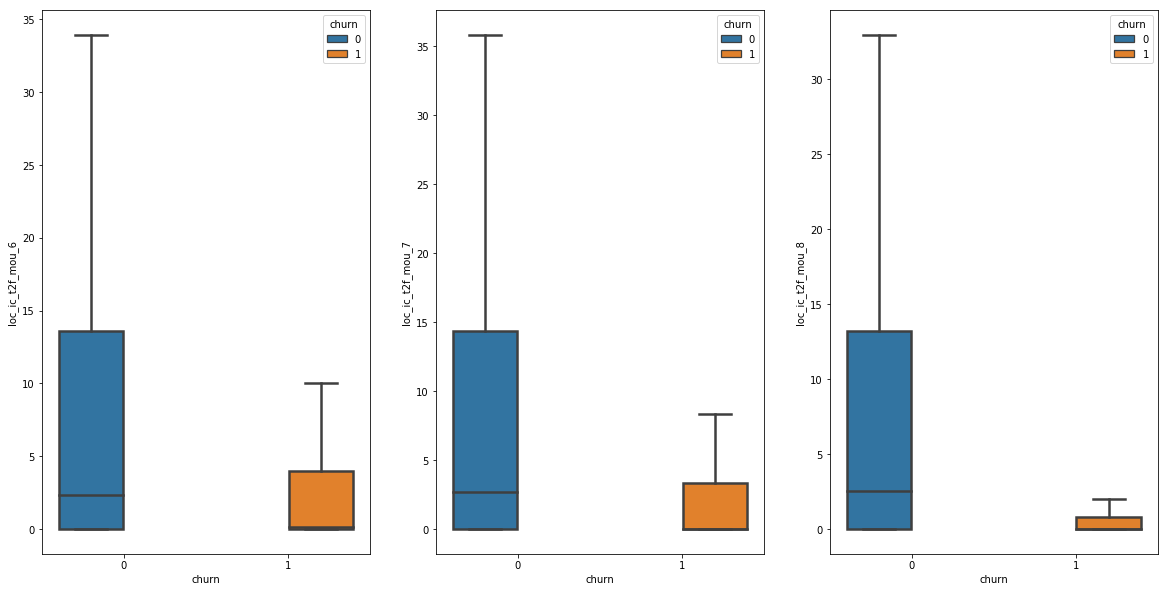

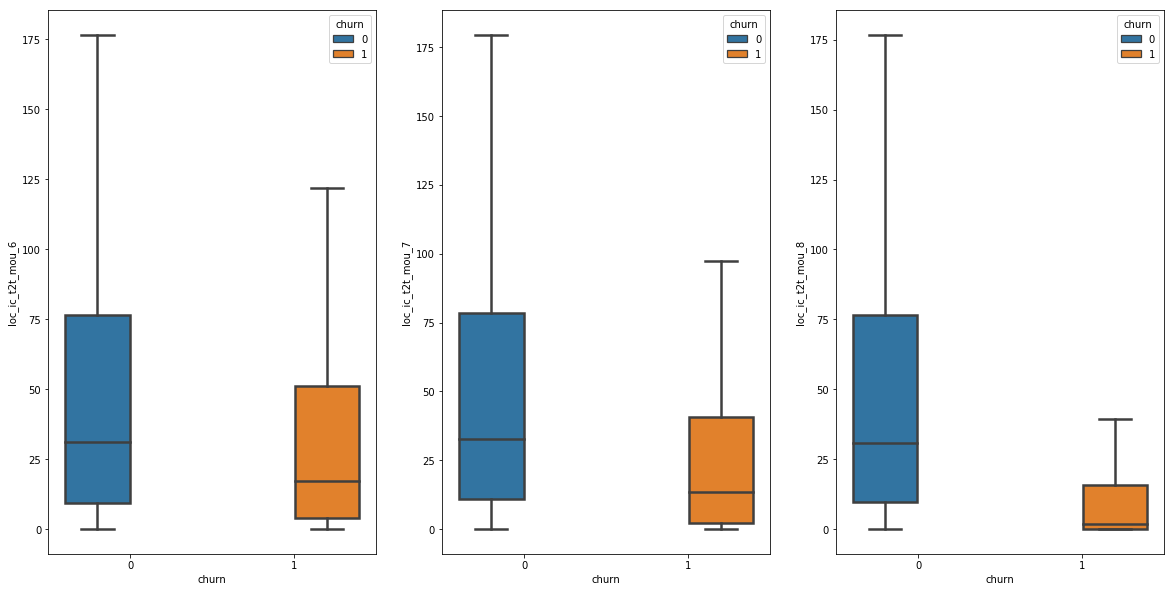

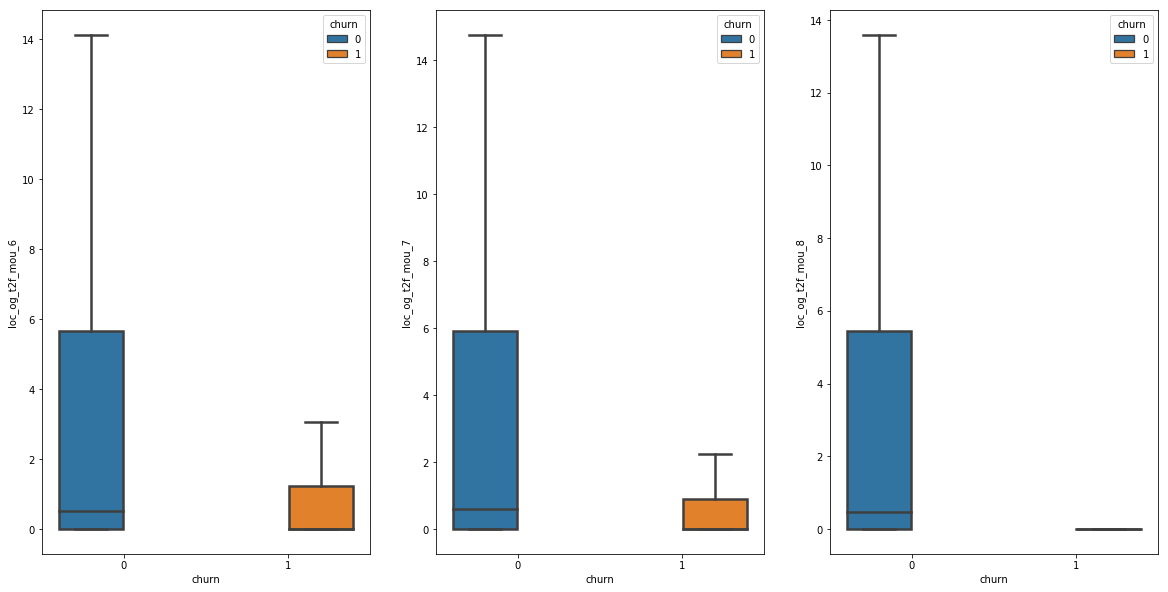

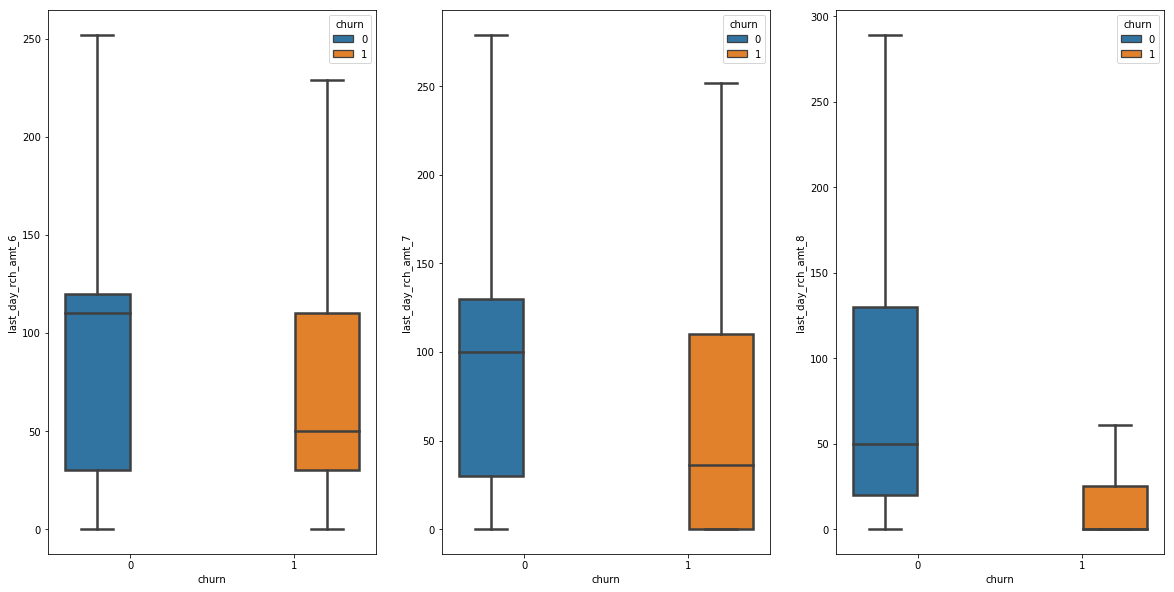

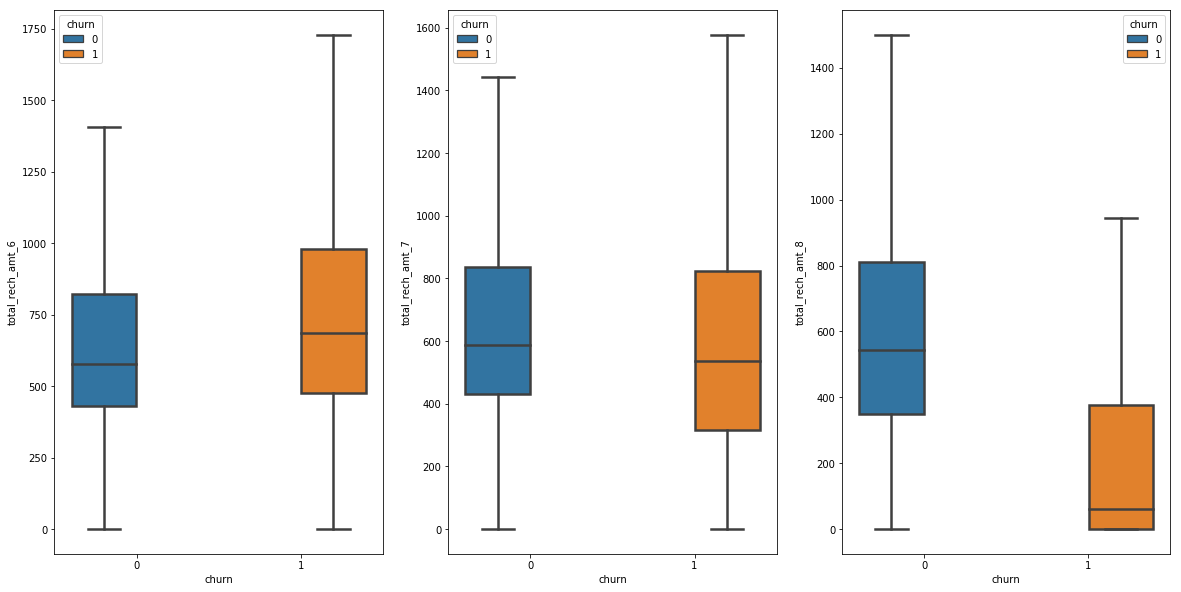

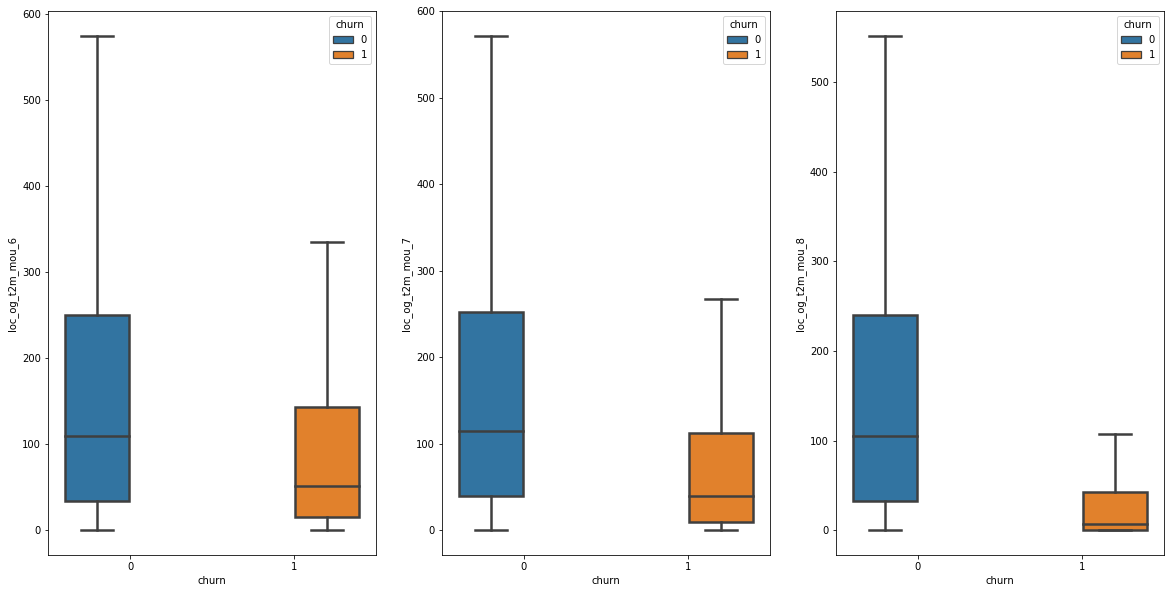

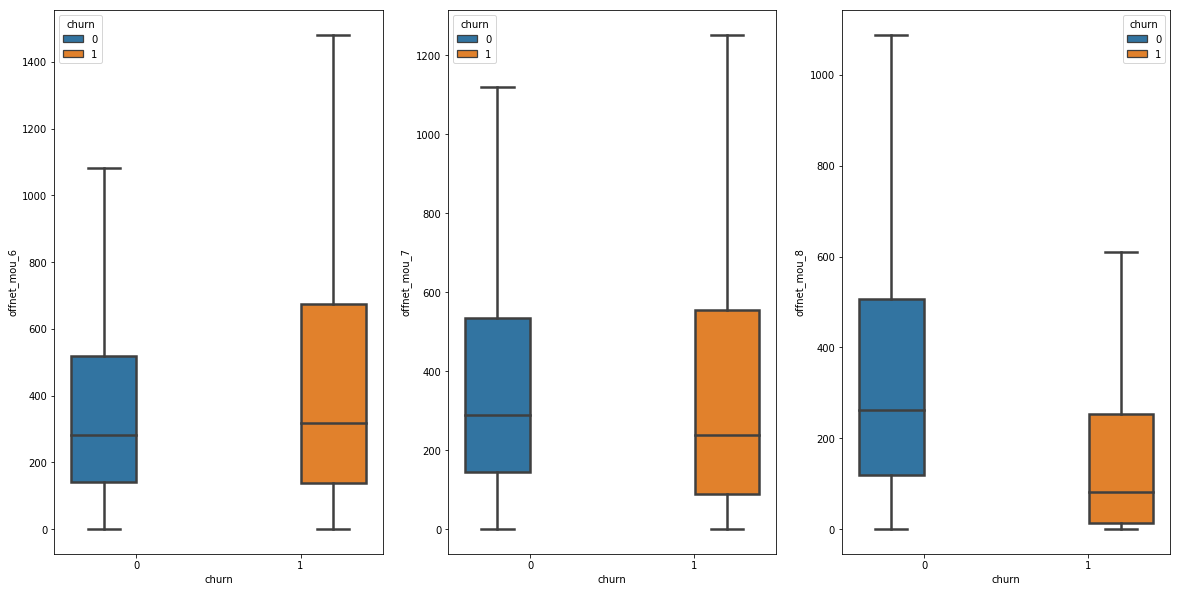

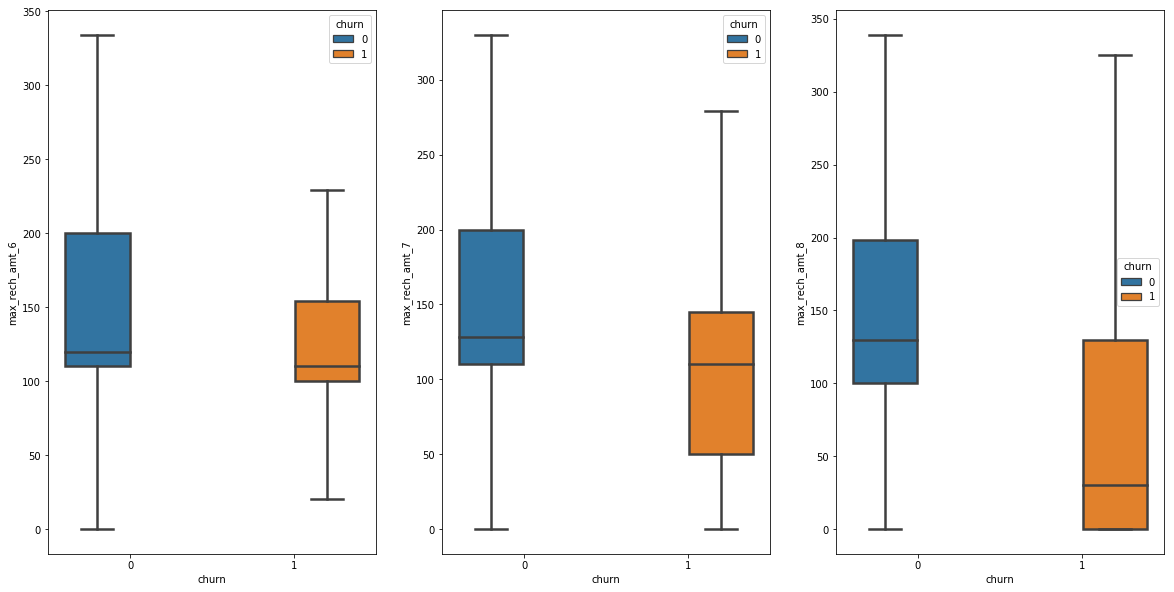

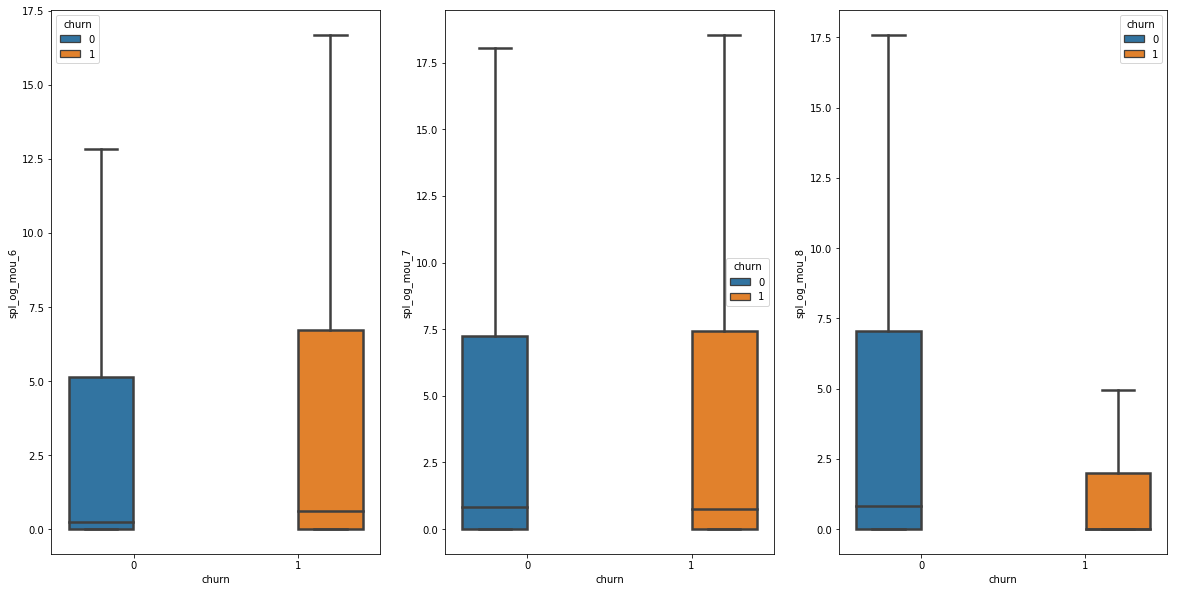

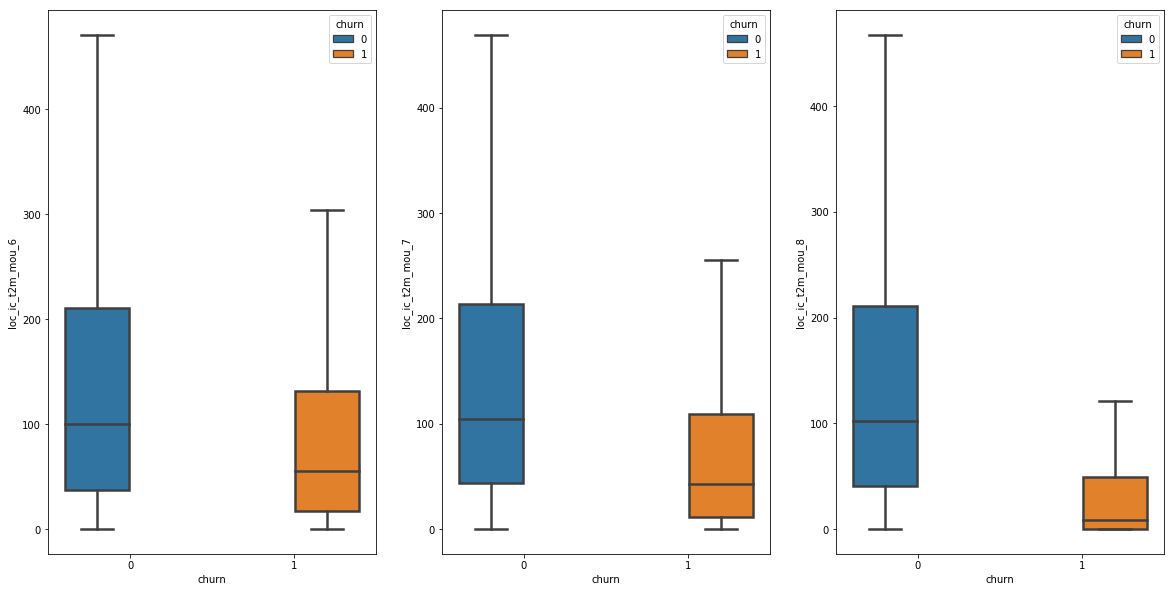

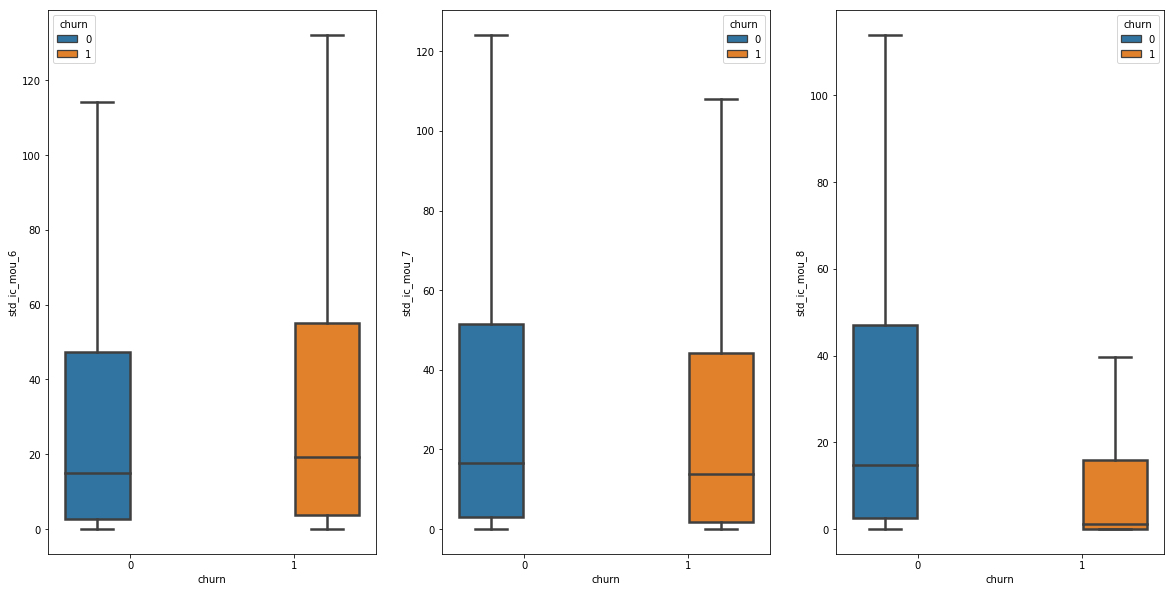

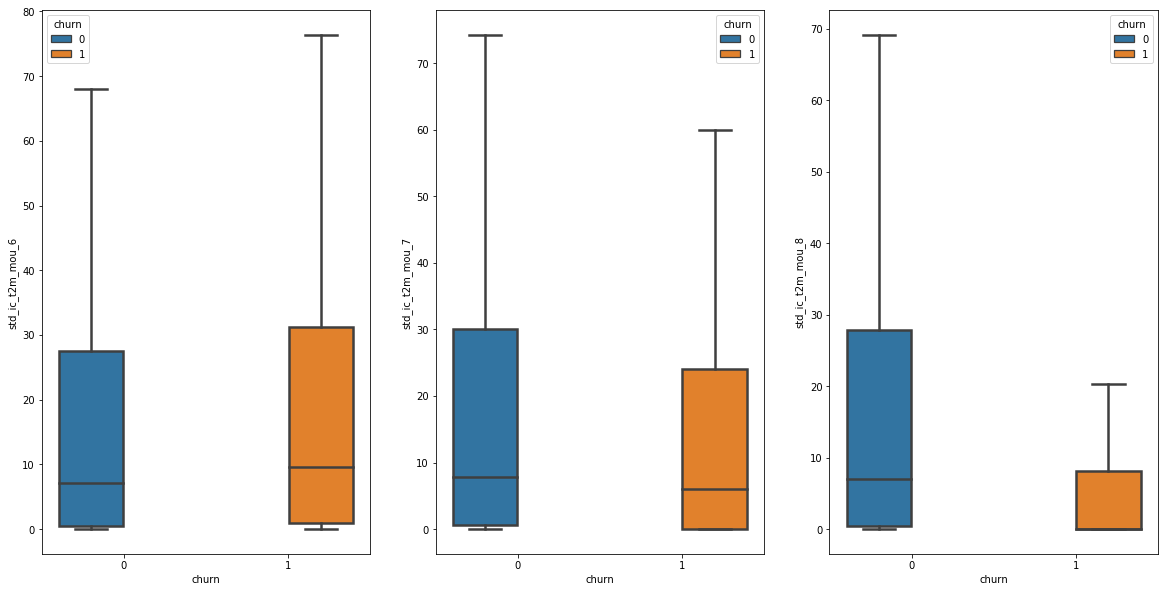

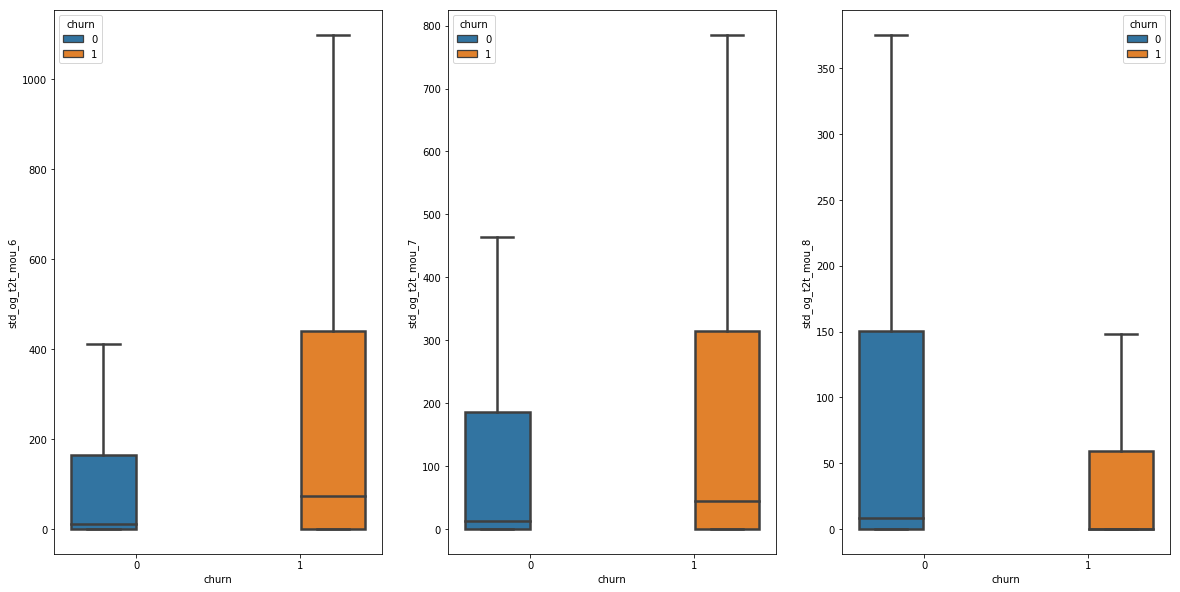

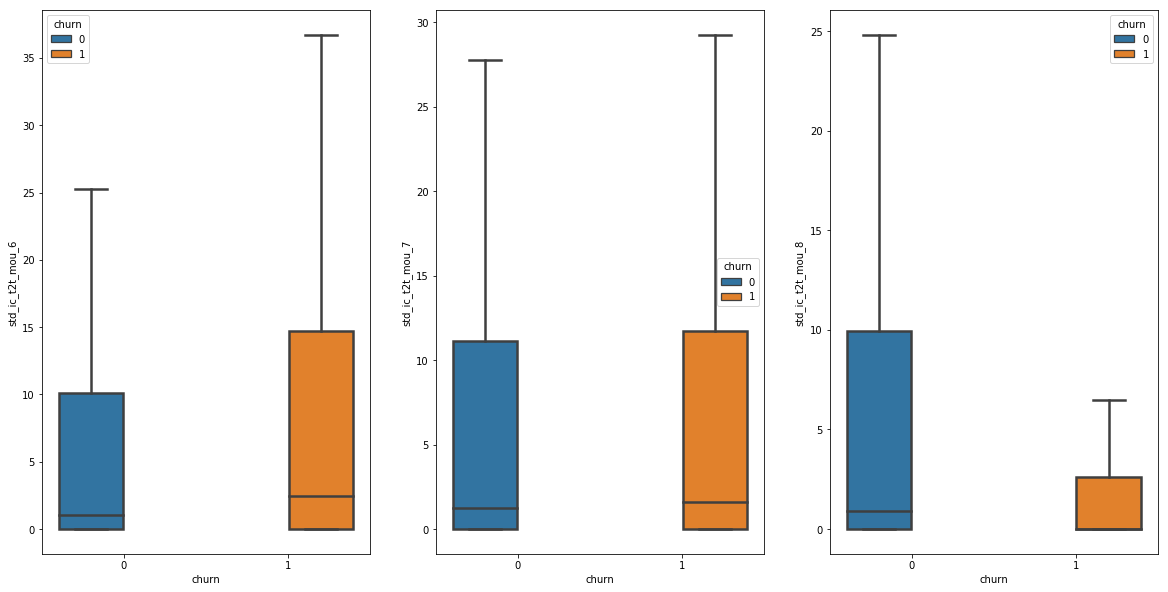

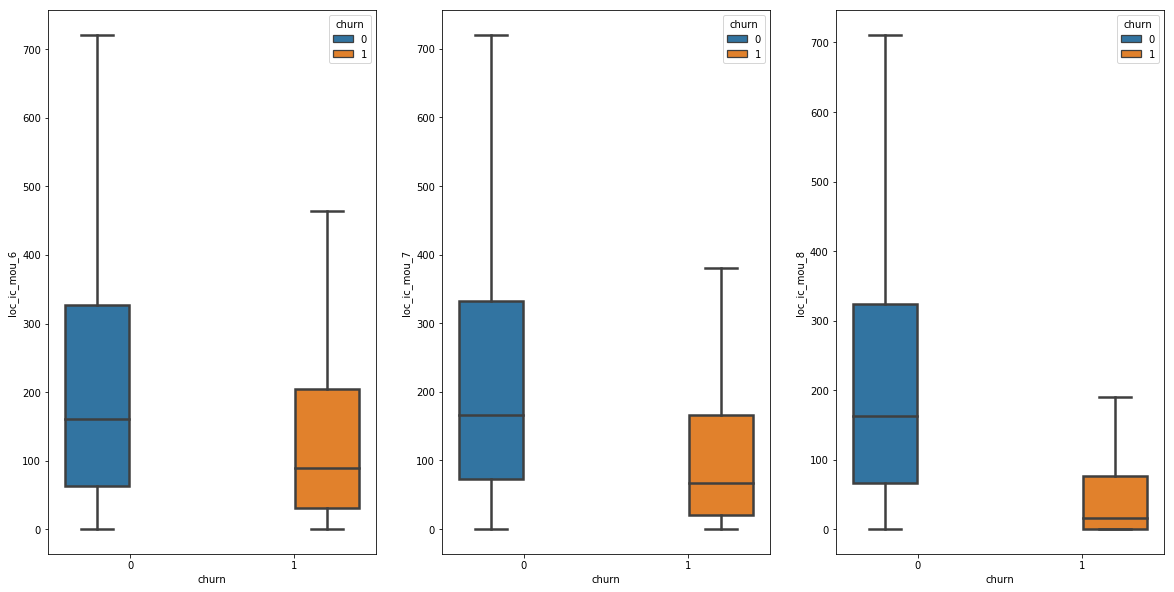

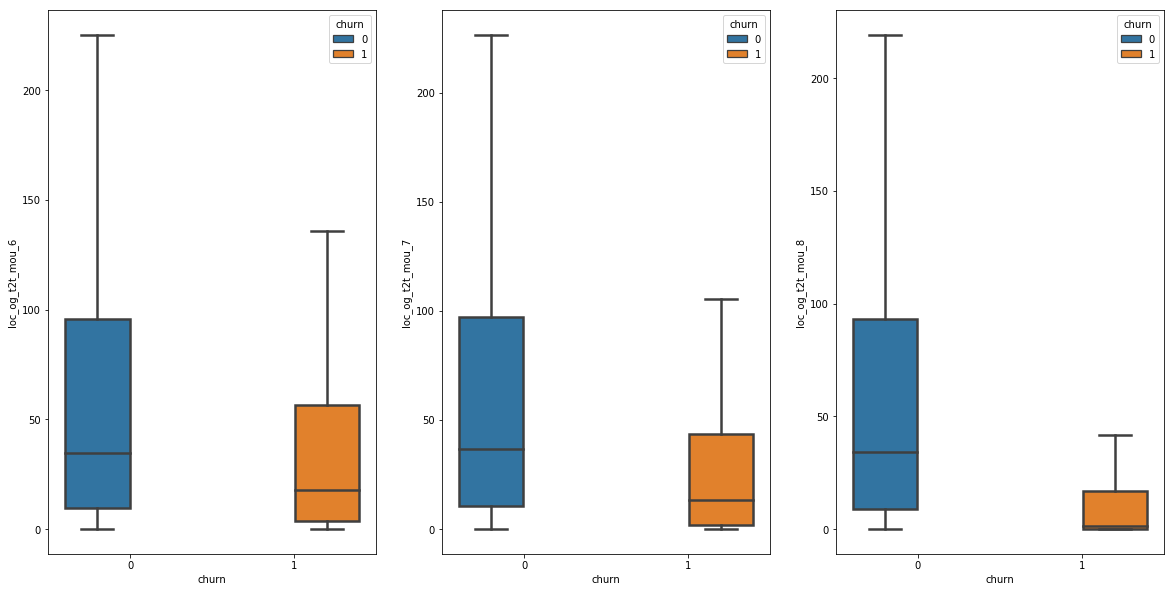

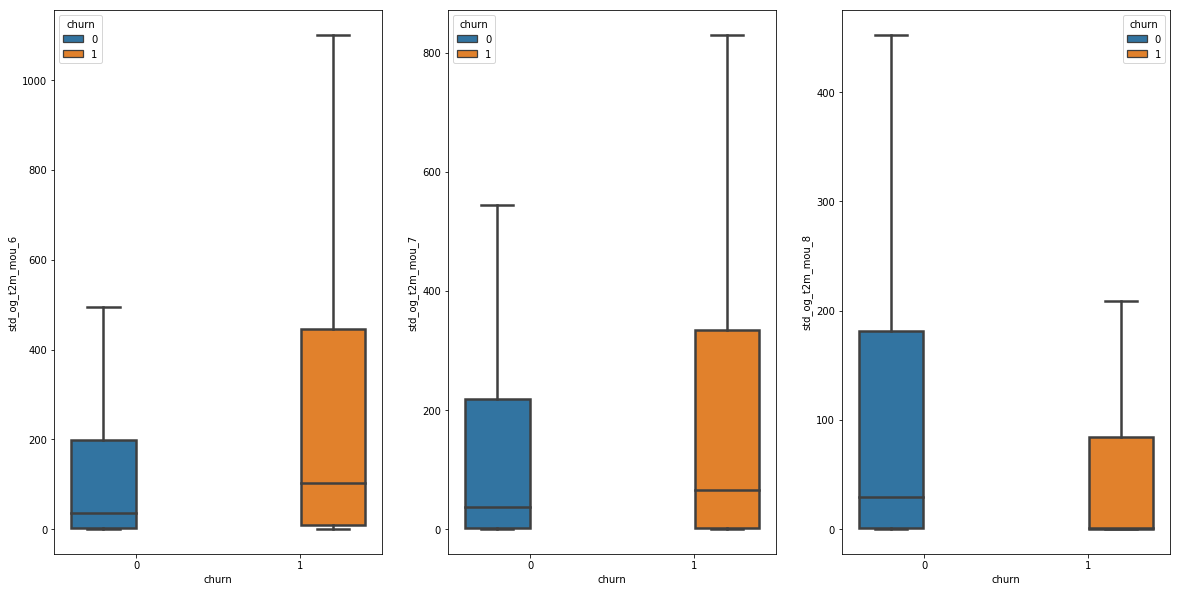

In [105]:
## For each column in phase_columns output a comparision
for phase_feature in phase_columns:
    print("ANALYZING: {}".format(phase_feature[:-2]))
    analyze_feature(phase_feature[:-2])

Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 605.0828622662567 Avg 425.2376357056695 max_feat 7011.11
Month 7
Total Rows: 2434 Std. dev. 537.1694572660736 Avg 336.1389687756779 max_feat 8157.78
Month 8
Total Rows: 1857 Std. dev. 387.82619229899393 Avg 168.16773828756058 max_feat 5193.66


/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


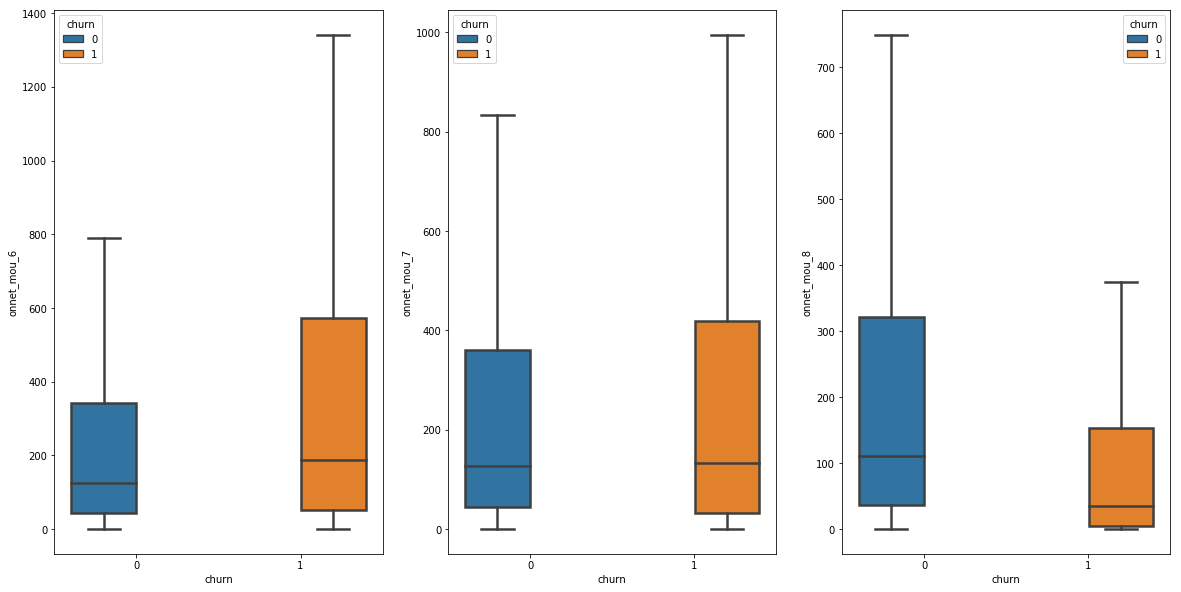

In [73]:
"""
Observations:
-- arpu (Average revenue per user)
Significant drop in arpu in 8th month
-- total_rech_num (Total times recharged)
Significant drop in num
-- std_og_mou outside / outgoing / minutes of usage
Significant drop, however seems uncompareabel to NON churn
-- loc_og_mou LOCAL outgoing
Siginficant drop ==> almost drops to ZERO
-- TOTAL ougoing ==> significant drop in CHURN
-- TOTAL incoming MOU ==> SIGNIFICANT DROP in CHURN
"""

Churn Stats:
Month 6
Total Rows: 2487 Std. dev. 9.56821050562059 Avg 1.7663610776035386 max_feat 336.13
Month 7
Total Rows: 2434 Std. dev. 11.659634758559735 Avg 2.1964092029580935 max_feat 428.88
Month 8
Total Rows: 1857 Std. dev. 6.046304094804923 Avg 1.2759935379644591 max_feat 128.19


/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


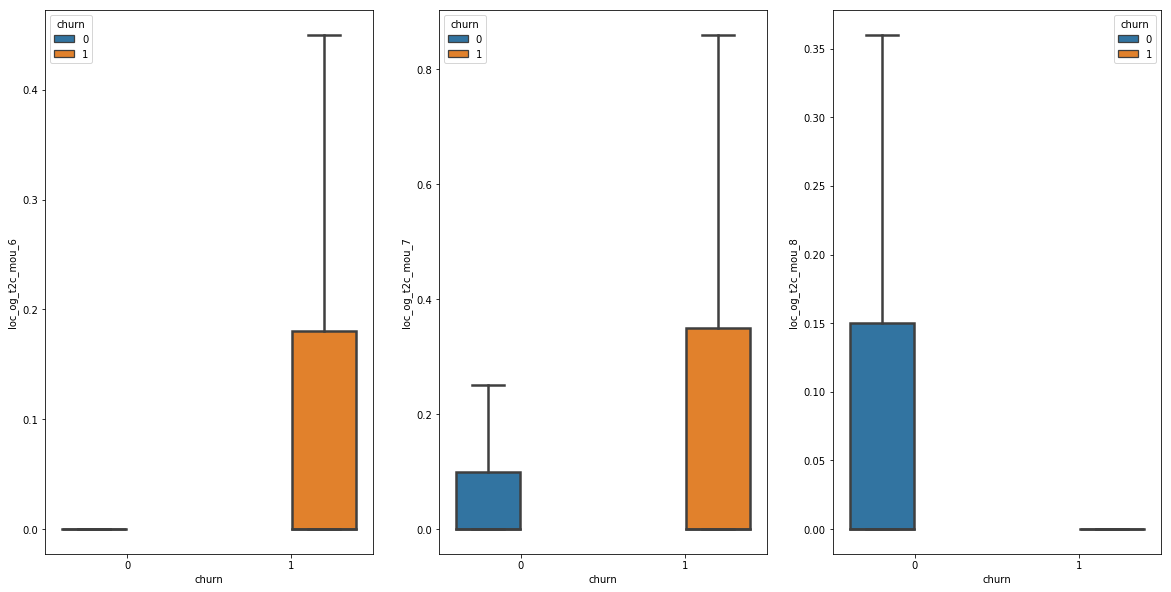

In [107]:
analyze_feature("loc_og_t2c_mou")
# HIGH in forst two months, then drops